In [1]:
using BenchmarkTools, SpecialFunctions
using LinearAlgebra, Statistics
using Parameters
using Plots
using Optim #https://github.com/JuliaNLSolvers/Optim.jl
using Random, Distributions
gr(fmt=:png); # setting for easier display in jupyter notebooks
using TypedTables
using ThreadsX, Folds # these are multithreading tools
using QuantEcon
using SparseArrays
using BasisMatrices

In [2]:
model_params = @with_kw (
    β= 0.96,
    R = 1.0292,
    γ = 3.0,
    amin = -3.0,
    amax = 16.0,
    Na=100,
    agrid = range(amin,amax,length=Na),
    Nshocks = 7,
    ρ = 0.20,
    σ = 0.3919,
    mc= rouwenhorst(Nshocks, ρ, σ),
    Niter = 500,
    )

##NamedTuple_kw#257 (generic function with 2 methods)

In [186]:
function consumption(R, a, ap, w)
    
        c = R*a .- ap .+ w
    
    return c
    
end

##########################################################################
##########################################################################

function utility(c, γ)
    
    if abs(γ - 1.0) < 1e-10
        
        (c < 1e-5 ? -1e10 : log(c)) 

    else
        (c < 1e-5 ? -1e10 : c^( 1.0 - γ) / (1.0 - γ)) 
    end

end

##########################################################################
##########################################################################

function make_utility(model_params)
    
    @unpack Na, Nshocks, γ, R, mc, agrid = model_params
    
    utility_grid = Array{Float64}(undef, Na, Na, Nshocks)
    
    a =  reshape(agrid, Na, 1)
    
    a_prime = reshape(agrid, 1, Na)
    
    for xxx = 1:Nshocks
        
        c = consumption(R, a, a_prime, exp.(mc.state_values[xxx]))
        
        utility_grid[:, :, xxx] = utility.(c, γ)
    
    end
    
    return utility_grid
    
end

##########################################################################
##########################################################################

function compute_EV(v::Array{T}, mc_probs::Vector{T}) where T
     
    # so mc_probs should be a 1 by Nshock row vector 
    # then v should be Nassset state, Nshock state matrix
    # we want to integrate this so transpose, so for a given
    # asset state integrate accross different shock outcomes
    
    return  (mc_probs' * v' )
    
end

##########################################################################
##########################################################################

function bellman_operator(u::Array{T}, βv::Array{T}, mc_probs::Vector{T}) where T
        
    βEV = compute_EV(βv, mc_probs)
        
    vprime, policy_index = findmax( u .+ βEV , dims = 2)
    
    return vprime, policy_index
    
end

##########################################################################
##########################################################################

function value_function_itteration(model_params ; tol = 10^-3)
    
    @unpack Na, Nshocks, Niter, β, mc = model_params
    
    u = make_utility(model_params)

    Tv = zeros(Na, Nshocks)
    
    v = similar(Tv)

    for iter = 1:Niter

        for xxx = 1:Nshocks
                    
            βEV = compute_EV(β*Tv, mc.p[xxx,:])
        
            Tv[:, xxx]  = maximum(u[:, :, xxx] .+ βEV , dims = 2)
            #this is faster than findmax, but only returns max, not
            # index, ok for itteration

        end
    
        test_tol = norm(Tv - v)
        
        if test_tol < tol
            
            #println("value function converged")
            #println(iter)
            #println(test_tol)
                        
            break
        end
        
        v = copy(Tv);

    end
    
    aindx = Array{CartesianIndex{2}}(undef, size(Tv))
            
    for xxx = 1:Nshocks
                    
        βEV = compute_EV(β*Tv, mc.p[xxx,:])
        
        Tv[:, xxx], aindx[:, xxx] = findmax(u[:, :, xxx] .+ βEV , dims = 2)
        # now get the policies

    end
    
    return Tv, aindx
end

##########################################################################
##########################################################################


function make_transition_prob(model_params, asset_indx::Matrix{CartesianIndex{2}})
      
    @unpack Na, Nshocks, mc = model_params

    statesize = convert(Int64, Na*Nshocks)
    
    transition_prob = Array{Float64}(undef, statesize, statesize)

    for ast = 1:Na
        
        ast_counter = convert(Int64, (ast - 1)*Nshocks)
            
        for shk = 1:Nshocks
            
            foo = zeros(1, Na)
    
            foo[asset_indx[ast, shk][2]] = 1.0
    
            transition_prob[shk + ast_counter, :] = BasisMatrices.row_kron(foo, mc.p[shk,:]' )
            # this part on the row still confuses me a bit...need to explain better.
            
            #println(shk + ast_counter)
            
        end
        
    end
    
    return transition_prob
    
end

make_transition_prob (generic function with 1 method)

In [123]:
@btime value_function_itteration(test ; tol = 10^-3);

  88.838 ms (15638 allocations: 180.12 MiB)


In [177]:
@btime value_function_itteration(test ; tol = 10^-3);

  53.941 ms (21063 allocations: 178.43 MiB)


  0.093660 seconds (21.07 k allocations: 178.430 MiB, 12.82% gc time)
vfi done
  0.005425 seconds (2.10 k allocations: 8.278 MiB)
transmat done
  0.110884 seconds (6.37 k allocations: 10.156 MiB)
stationary done


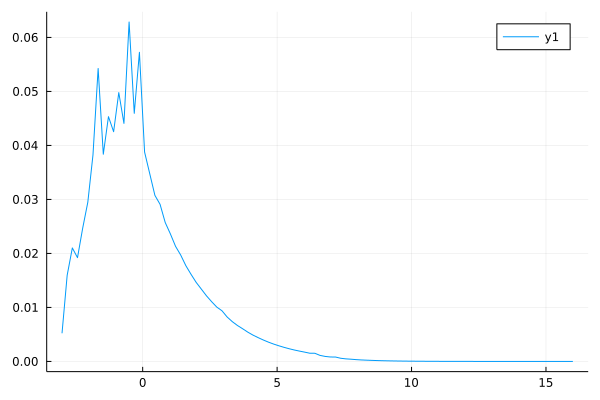

In [189]:
test = model_params(σ = 0.3919, Nshocks = 7, Na = 100, amin = -3.0, amax = 16)

@time vfout, pout = value_function_itteration(test ; tol = 10^-3);

println("vfi done")

@time tprob = make_transition_prob(test, pout);

println("transmat done")

@time st  = stationary_distributions(MarkovChain(tprob))[1]
# this part is very slow...

println("stationary done")

st = reshape(st,test.Nshocks,test.Na)'

plot(test.agrid, sum(st, dims = 2))